In [1]:
import numpy as np      
import pandas as pd
import matplotlib.pyplot as plt 
import csv

# 2 Grouping songs together!

The final goal of this part is to group songs into similar genres (without using the feature genre in our K-means anaylsis)

## 2.1  Getting the data and Data Wrangling

We start by reading the datasets we where given.

In [2]:
tracks = pd.read_csv("tracks.csv")
echonest = pd.read_csv("echonest.csv")
features = pd.read_csv("features.csv")

**Traks dataset**

We see that the datasets have many features (e.g. *tracks.csv* has 106574 rows and 53 columns).

In [3]:
print(tracks.shape)
tracks.head()

(106574, 53)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [52]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        103045 non-null  object 
 3   album_date_released       70294 non-null   object 
 4   album_engineer            15295 non-null   object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         83149 non-null   object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            18060 non-null   object 
 10  album_tags                106574 non-null  object 
 11  album_title               105549 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                100066 non-null  o

**Echonest dataset**

In [4]:
print(echonest.shape)
echonest

(13129, 250)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.676960,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.082770,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.926490,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.414010,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.267070,11.20267,26.454180,751.147705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,NaN,...,-1.721207,4.686078,0.213789,0.208800,0.007911,0.06395,2.040730,1.97678,8.144532,147.040405
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,...,-0.647897,1.282306,0.214586,0.181860,0.011247,0.06240,0.922360,0.85996,1.794739,6.321268
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,...,-0.771613,1.623510,0.180471,0.128185,0.010103,0.06222,2.251160,2.18894,5.578341,89.180328
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,...,-2.054143,7.927149,0.250178,0.219205,0.014851,0.06390,1.487440,1.42354,2.173092,12.503966


In [50]:
echonest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB


**Features dataset**

In [5]:
print(features.shape)
features.head()

(106574, 519)


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [53]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


### Cleaning of the datasets

Since the `track_id` seems one of the most important features we check wheter there are missing or duplicate values in these columns

In [6]:
print(tracks["track_id"].isnull().any())
print(features["track_id"].isnull().any())
print(echonest["track_id"].isnull().any())

False
False
False


In [48]:
if tracks.track_id.nunique() == len(tracks["track_id"]):
    print("No duplicate track ids")
else:
    print("There are duplicate track ids")

No duplicate track ids


By exploring the datasets, we've seen that some columns have many NaN values and strange entries (e.g. in `album_information`). For this reason we start filling and cleaning  the datasets. The filling part is done following some rules of thumb (see the `fill` function below):
- replace a missing numeric values (as NaN) with the mean of all the numeric values of the same kind
- replace all the NaN strings with a blanc space 

The cleaning part is done by replacing some unpleasant html tags-type-of-strings. For example in the `album_information` column of the `tracks` datasets there are strings like `<p>` we wolud like to eliminate (see the `clean` function below)

In [8]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [9]:
def fill(df):
    """
    Input: df, a dataframe
    Output: None
    Remark: the function performs some trasformations on the columns of the dataframe given in input, in particular:
                - if there is a missing numeric value (as NaN) it fills it with an average value
                - if there is a string wich is NaN it replaces it with a blanc space 
    """
    for i in df.columns:
        if df[i].isnull().any() == True:
            if is_numeric_dtype(df[i]) == True:
                df[i] = df[i].fillna(df[i].mean())
            elif is_string_dtype(df[i]) == True:
                    df[i] = df[i].fillna("")

In [10]:
def clean(df):
    """
    Input: df, a dataframe
    Output: None
    Remark: the function replaces every html substring in the dataframe's columns with a blanc space
    """
    for i in df.columns:
            if is_string_dtype(df[i]) == True:
                    df[i] = df[i].str.replace(r'<[^<>]*>', '', regex=True)

In [11]:
# copy the datasets in order to keep the original files unchanged
cleaned_tracks = tracks.copy()
cleaned_echonest = echonest.copy()
cleaned_features = features.copy()

In [12]:
fill(cleaned_tracks)

In [13]:
clean(cleaned_tracks)

**Remark .** In 2.2 we will apply PCA and to do so we will need to process and transform the datasets (standardization). In the this phase we will rescale the numeric columns. Since `album_id` and `artist_id` are a fixed number that corresponds to an album and an artist we don't want to change them in the process. This is why we will momentarely drop these features.  

In [14]:
cleaned_tracks = cleaned_tracks.drop(["album_id", "artist_id"], axis = 1)

In [15]:
print(cleaned_tracks.shape)
cleaned_tracks.head()

(106574, 51)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_information,album_listens,album_producer,album_tags,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],...,,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,,3,,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],...,,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,,4,,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],...,,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,,6,,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,,47632,,[],...,,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,,1,,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,,2,"""spiritual songs"" from Nicky Cook",2710,,[],...,,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,,3,,[],Spiritual Level


We now will fill and clean the `echonest` dataset.

In [16]:
fill(cleaned_echonest)

In [17]:
clean(cleaned_echonest)

In [18]:
print(cleaned_echonest.shape)
cleaned_echonest.head()

(13129, 250)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


**Remark .** We've decided to drop some columns to reduce the size of the `echonest` dataset. For example we believe that in our analysis `metadata_album_date`, `metadata_album_name` ecc... are not relevant, in particulare those features are most of the time empty.

In [19]:
cleaned_echonest = cleaned_echonest.drop(["metadata_album_date", "metadata_album_name"], axis = 1)

We now will fill and clean the `features` dataset.

In [20]:
fill(cleaned_features)

In [21]:
clean(cleaned_features)

In [22]:
cleaned_features.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


### Merge the datasets

As we saw with the exploratory data analysis, the `echonest` dataset has 13.129 unique `track_id`s, while the `features` and `tracks` dataset have 106.574 unique tracks_id. The datasets are related to each other:
- `echonest` has some information about the audio features, metadata, ranks ecc...
- `features` contains many numerical entries that should uniquely characterize the tracks.
- `tracks` contains many informations on the album, the artist and the track.

Since the datasets have `track_id` in common, we decided to use it as a key to join the datasets. In particular we will merge the datasets w.r.t. `track_id` keeping the `echonest` dataset's rows ($\sim 13000$ rows). We than fill and clean the dataset as it was done before.

In [23]:
# merge tracks and echonest w.r.t. track_id
first_merge = cleaned_tracks.merge(cleaned_features, on = "track_id")
dataset = first_merge.merge(cleaned_echonest, on = "track_id")

In [24]:
fill(dataset)

In [25]:
clean(dataset)

In [26]:
print(dataset.shape)
dataset.head()

(13129, 816)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_information,album_listens,album_producer,album_tags,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,,47632,,[],...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


## 2.2 Choose your features (variables)!
We have plenty of features to work with (> 800 columns). So, we will need to find a way to reduce the dimensionality. We will use **PCA** (Principal Component Analysis) for **Dimensionality Reduction**. 

**Disclamair**. We've gained many insight from https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad. 

In [27]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

Since we would like to apply PCA, first we need to select all the numeric features frome the dataset(s).

In [28]:
processed_dataset = dataset.select_dtypes([np.number])

In [29]:
print(processed_dataset.shape)
processed_dataset.head()

(13129, 778)


,track_id,album_comments,album_favorites,album_listens,album_tracks,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,4,47632,2,3,74,39.901626,-38.668642,192000,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


Now we "standardize" the features by removing the mean and scaling to unit variance. This transformations can be done using `sklearn preprocessing`, in particular using `sklearn.preprocessing.StandardScaler`.

**Remark .** In this preprocessing part we will ignore some features (e.g. `track_id`). Indeed it isn't good to change some fixed features that are related to the ordeting of the songs or the id of the tracks and the albums. Recall that we have already ignored `album_id` and `artist_id` in 2.1. At the end of this processing part we will restore some of the columns we have previously ignored.

In [30]:
# this dataset can be also be used to carry out some other dimensionality reduction
# we will use it for the PCA

df = processed_dataset

In [31]:
scaler = preprocessing.StandardScaler()

# processed dataset without trak_id as a feature
temp_df = pd.DataFrame(scaler.fit_transform(df[df.columns[1:]].values), columns = df.columns[1:])

In [32]:
# restore track_id feature in the processed dataset
final_df = pd.concat([df['track_id'], temp_df], axis = 1)

In [33]:
print(final_df.shape)
final_df

(13129, 778)


,track_id,album_comments,album_favorites,album_listens,album_tracks,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,0.000627,-0.643269,0.116230,...,-0.015394,-0.196498,-0.541629,-0.746474,-0.039156,-0.406800,-0.101961,-0.101075,0.886203,0.549691
1,3,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,0.000627,-0.643269,0.116230,...,0.224575,-0.092590,-0.360448,-0.411759,-0.023682,-0.402225,0.382370,0.383292,1.407079,0.827430
2,5,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,0.000627,-0.643269,0.116230,...,-0.188685,0.038956,-0.372166,-0.209735,-0.029780,-0.767287,0.350908,0.352630,1.304715,0.965630
3,10,-0.293923,0.757754,0.503120,-0.860517,0.293227,0.823212,-0.012197,0.140263,-0.886405,...,-0.993299,0.536708,-0.182877,0.139612,-0.010956,1.124812,0.851688,0.849294,2.127603,1.527072
4,134,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,0.000627,-0.643269,0.116230,...,0.300454,-0.418382,-0.530095,-0.666811,-0.004175,-0.377522,1.426057,1.427025,2.924718,2.714005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,-0.293923,-0.543561,0.661105,0.131767,-0.311831,-0.176100,-0.012197,0.140263,1.118865,...,0.143286,-0.302202,-0.679190,-0.556334,-0.044766,-0.418694,-0.431361,-0.430482,0.083651,0.035944
13125,124862,-0.293923,-0.543561,0.661105,0.131767,-0.311831,-0.176100,-0.012197,0.140263,1.118865,...,0.771528,-0.471946,-0.673505,-0.878092,-0.043808,-0.560510,-0.656508,-0.655338,-0.901632,-0.587877
13126,124863,-0.293923,-0.543561,0.661105,0.131767,-0.311831,-0.176100,-0.012197,0.140263,1.118865,...,0.699114,-0.454931,-0.916909,-1.519158,-0.044137,-0.576979,-0.388998,-0.387766,-0.314539,-0.220555
13127,124864,-0.293923,-0.543561,0.661105,0.131767,-0.311831,-0.176100,-0.012197,0.140263,1.118865,...,-0.051591,-0.140572,-0.419567,-0.432063,-0.042774,-0.423269,-0.542748,-0.541869,-0.842924,-0.560468


### PCA with 75 components in order to have > 70% of the total variance 
We decided to keep this number of features because it is both one order of magnitude less than the original number of features and a big enough to keep a good percentage of the original variance.

In [34]:
# Dimensionality reduction
pca = PCA(n_components=75)
df_pca = pca.fit_transform(temp_df)
print(sum(pca.explained_variance_ratio_))

0.7164900886497907


In [35]:
# convert the result of PCA into a pandas dataframe
final_df_pca = pd.DataFrame(df_pca, columns = ['Feature_%i' % i for i in range(75)])

In [36]:
# add back the track_id feature in the reduced dataset
final_reduced_dataset = pd.concat([df['track_id'], final_df_pca], axis = 1)

In [37]:
final_reduced_dataset

,track_id,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,Feature_74
0,2,3.074302,-2.797337,-5.727161,4.275846,3.145518,2.026032,6.743277,-0.949347,-2.280776,...,-0.586116,-0.521783,-1.315860,1.283339,1.948948,-0.876177,-0.448808,-0.221877,0.300597,-0.497990
1,3,5.774573,-5.391473,-5.295096,-1.595908,-3.639362,2.654712,-1.537518,5.894227,-0.188972,...,-0.621176,-0.464410,0.385781,-0.040496,0.023872,-0.462862,0.046987,-1.355453,-2.119339,1.944162
2,5,2.652206,-4.147719,-4.569169,-0.059658,-2.859906,2.085989,-1.290576,-0.334101,-0.132213,...,0.771575,0.732262,-1.040053,1.077393,0.528545,0.044783,-0.401445,-0.046670,-2.761415,1.856758
3,10,9.135480,3.848567,-5.450891,0.691603,-1.308854,0.611628,-1.807103,4.077703,-0.602840,...,0.332784,-3.321410,2.555124,-1.366604,-2.825010,0.461177,-1.241053,-3.322562,-1.191797,1.223716
4,134,1.306864,-9.430185,-4.282517,0.701471,-3.849181,-1.255676,-2.946912,-2.203397,-0.537648,...,-0.004788,0.676728,-0.222239,1.453200,0.675676,-1.051188,-0.432454,0.304385,-2.527179,1.605823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,7.730822,-5.736460,-1.115029,-1.531799,-2.110758,0.031888,1.277210,-0.984297,-1.060890,...,-0.908566,-0.548243,0.117421,-0.427579,0.169958,0.251562,0.389073,0.796552,-0.503800,1.903071
13125,124862,15.123638,-5.157335,-1.372574,11.646076,-1.460499,-0.916496,-1.332105,-3.542078,0.536494,...,0.427417,0.529034,0.948641,-2.293639,1.450501,-0.469833,0.676920,2.016325,-0.554994,2.666790
13126,124863,18.033321,-3.912602,-1.727583,5.016463,-2.362588,3.155801,4.638053,-4.964479,1.350635,...,0.225642,0.010589,0.437143,-0.464300,1.834470,0.393520,0.195185,1.685018,0.188308,-1.007166
13127,124864,-2.900728,-1.702230,-0.381814,-6.061831,-1.468292,-0.222357,3.345313,6.342345,0.882050,...,0.402044,0.083643,-0.040499,0.245543,0.545974,0.401262,1.314327,0.452344,0.542356,0.553165


**Questions:**
- how to recover the original names of the features in the reduced dataset?
- how to know weather some important features (e.g. lenguage, duration...) has been lost?


### Interpretation of the results
By plotting the contribution of each components to the retained total variance we see that the first features contribute the most to the retained variance. We se, for example, that `Feature_0` contributes to the 10.5% of the total variance and uccessive features then contribute lesser and lesser.

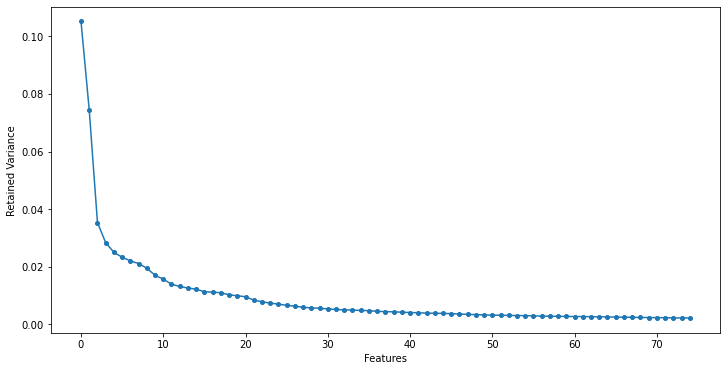

In [38]:
fig = plt.figure(figsize=(12,6))
plt.plot(pca.explained_variance_ratio_, marker=".", markersize=8)
plt.ylabel('Retained Variance')
plt.xlabel('Features')
plt.show()

In [66]:
pca.explained_variance_ratio_

array([0.10513059, 0.07437813, 0.03536327, 0.02835865, 0.02502433,
       0.02332415, 0.02205029, 0.021143  , 0.01952043, 0.01705815,
       0.01571154, 0.01398093, 0.01317964, 0.01263634, 0.01222312,
       0.01135262, 0.0112229 , 0.01100859, 0.01028568, 0.00996207,
       0.00962207, 0.00844139, 0.00787604, 0.0074077 , 0.00706005,
       0.00663206, 0.00637189, 0.00594595, 0.00574162, 0.00563065,
       0.0053955 , 0.00521061, 0.00506048, 0.00501109, 0.00485086,
       0.00479021, 0.0045399 , 0.00445211, 0.00437899, 0.00425407,
       0.00413706, 0.00407705, 0.00392387, 0.00387705, 0.00383287,
       0.00375754, 0.00361792, 0.00351004, 0.00340298, 0.00330676,
       0.00322605, 0.00320711, 0.00313305, 0.00309468, 0.00304948,
       0.00299752, 0.00288833, 0.00285806, 0.00282166, 0.00279062,
       0.00275205, 0.00273592, 0.00269404, 0.0026622 , 0.00263854,
       0.00254526, 0.00252947, 0.00248627, 0.00242263, 0.00240876,
       0.00237467, 0.00234379, 0.00227966, 0.00226731, 0.00225

The following plot shows that by increasing the number of retained features the total retained variance increases. It is interesting to note that by keeping just 30 features we would have retained more than the 50% of the total variance. This suggests that many initial features where redundant.

In [61]:
var = np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 3)*100)

In [64]:
var

array([10.5, 17.9, 21.4, 24.2, 26.7, 29. , 31.2, 33.3, 35.3, 37. , 38.6,
       40. , 41.3, 42.6, 43.8, 44.9, 46. , 47.1, 48.1, 49.1, 50.1, 50.9,
       51.7, 52.4, 53.1, 53.8, 54.4, 55. , 55.6, 56.2, 56.7, 57.2, 57.7,
       58.2, 58.7, 59.2, 59.7, 60.1, 60.5, 60.9, 61.3, 61.7, 62.1, 62.5,
       62.9, 63.3, 63.7, 64.1, 64.4, 64.7, 65. , 65.3, 65.6, 65.9, 66.2,
       66.5, 66.8, 67.1, 67.4, 67.7, 68. , 68.3, 68.6, 68.9, 69.2, 69.5,
       69.8, 70. , 70.2, 70.4, 70.6, 70.8, 71. , 71.2, 71.4])

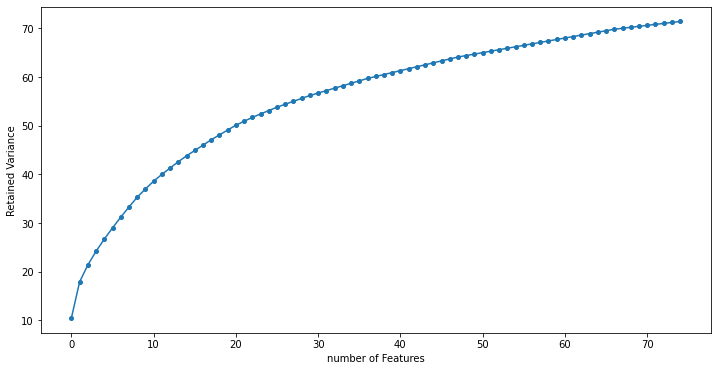

In [65]:
fig = plt.figure(figsize=(12,6))
plt.plot(var, marker=".", markersize=8)
plt.ylabel('Retained Variance')
plt.xlabel('number of Features')
plt.show()

# 3. Algorithmic questions

Given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal x.

*Example* . If $A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]$ and $s = 4$, then the algorithm should output: $(7, -3), (-2, 6), (2, 2), (3, 1)$.

A **simple solution** is to inspect each element of the list and check if there’s another number in the array which can be added to it to give sum. The simple solution has complexity $O(n^2)$ wich can be improved (e.g. by sorting the array first and than using binary search). A **second and more efficient solution** is given using Hash Tables: 
- Consider a Hash Table H 
- For each element $A[i]$ check if $s-A[i]$ is in $H$ 

The time complexity in this case is $O(n)$. 

**Disclamair**. A useful discussion of the problem can be found here: https://afteracademy.com/blog/check-for-pair-in-an-array-with-a-given-sum

In [40]:
# Matteo's code
from itertools import combinations
def algo1(A, s):
    a = combinations(A, 2)
    return list(filter(lambda x: sum(x) == s, a ))

In [41]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 4

In [42]:
algo1(A, s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

In [43]:
# Matteo's suggestion
# Same idea, but using an upper triangular matrix
def algo2(A,s) :
    l=[]
    for i in range (len(A)-1):
        for j in range (i + 1, len(A)):
            if (A[i] + A[j] == s):
                l.append((A[i] , A[j]))
    return(l)

In [44]:
algo2(A,s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

In [45]:
# Efficient solution with Hash tables
def algo3(A,s):
    count = 0
    # the set X will work as an Hash Table for the list A
    X = set(A)
    # list to keep track of all the pairs with sum s
    couples = []
    
    for item in A:
        if s - item in X:
            # min and max are used to discard duplicates
            couples.append ((min(item, s-item), max(item, s-item)))
            count+=1
    set_pairs = set(couples)
    print ("Pairs which sum up to ",s," are: ", set_pairs)


In [46]:
algo3(A,s)

Pairs which sum up to  4  are:  {(-2, 6), (1, 3), (2, 2), (-3, 7)}
